In [1]:
import sys

sys.path.append('../')

In [2]:
from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [3]:
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models import *
from mrl.agent import *
from mrl.vocab import *
from mrl.callbacks import *
from mrl.callbacks.template_cb import *
from mrl.agent import *
from mrl.policy_gradient import *
from mrl.loss import *
from mrl.sampler import *
from mrl.environment import *
from mrl.reward import *

In [4]:
os.environ['ncpus'] = '0'
torch.cuda.set_device(0)
set_global_pool(cpus=8)

# setup

In [5]:
df = pd.read_csv('/home/dmai/smiles_datasets/linkers.csv')

In [6]:
reference = 'c1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCOCCn1ccnc1[N+](=O)[O-]'
smile1 = '*c1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1'
smile2 = '*n1ccnc1[N+](=O)[O-]'
old_linker = '*OCCOCC*'

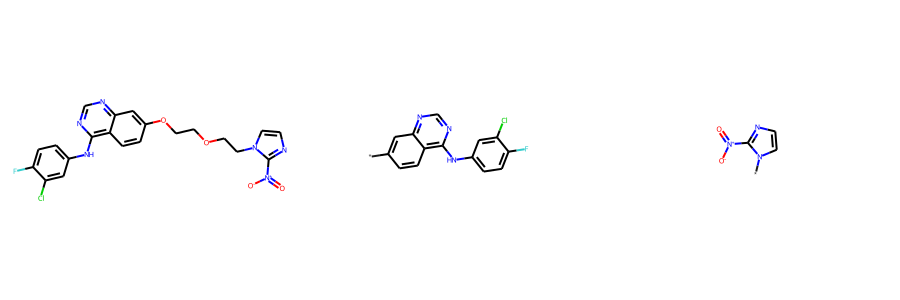

In [7]:
draw_mols(to_mols([reference,smile1, smile2]))

In [8]:
linker_template = Template(
                    [MolWtFilter(20, 200),
                     RingFilter(None,0)],
                    [],
                    fail_score=-1, log=False
                    )

smarts = ['[#6](=[#16])(-[#7])-[#7]',
        '[H]-[#6](-[H])=[#6]-[*]',
        '[#6]=[#6]=[#6]',
        '[#7][F,Cl,Br,I]',
        '[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]']



full_template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 13),
                     HeteroatomFilter(None, 15),
                     ChargeFilter(None, 0),
                     MaxRingFilter(None, 6),
                     MinRingFilter(5, None),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     MolWtFilter(None, 550),
                     LogPFilter(None, 5),
                     SAFilter(None, 7),
                     BridgeheadFilter(None,0),
                     PAINSAFilter(),
                     ExclusionFilter(smarts, criteria='any'),
                     RotChainFilter(None, 10)
                    ],
                    [], 
                    fail_score=-10., log=False, use_lookup=True)

template = LinkerBlockTemplate(smile1, smile2, linker_template,
                                    full_molecule_template=full_template)

In [9]:
df['mapped'] = df.smiles.map(lambda x: template.nodes[3].add_mapping(x))

In [10]:
df

,smiles,weight,atoms,mapped
0,*N(*)C(=O)C(CC(C)C)NC(C)=O,170.105528,12,[2*:1]N([2*:2])C(=O)C(CC(C)C)NC(C)=O
1,*CC(CC)C(=O)OCC(=O)NC(*)=O,185.068808,13,[2*:2]CC(CC)C(=O)OCC(=O)NC([2*:1])=O
2,*C=CC(=O)NCCCNC*,140.094963,10,[2*:1]C=CC(=O)NCCCNC[2*:2]
3,*CNCC(C)NC(=O)CC(F)(F)C(*)F,210.097998,14,[2*:1]CNCC(C)NC(=O)CC(F)(F)C([2*:2])F
4,*COC(=O)C(C)(C)CC(*)C,142.099380,10,[2*:2]COC(=O)C(C)(C)CC([2*:1])C
...,...,...,...,...
1167771,*CCCCCCCS(=O)(=O)CC(=O)C(*)(F)F,254.078822,16,[2*:1]CCCCCCCS(=O)(=O)CC(=O)C([2*:2])(F)F
1167772,*CCCCCCCCCCCCCCC(=O)OC(*)C,268.240230,19,[2*:1]CCCCCCCCCCCCCCC(=O)OC([2*:2])C
1167773,*C(C)C(=O)OC(*)S(=O)(=O)O,165.993594,10,[2*:2]C(C)C(=O)OC([2*:1])S(=O)(=O)O
1167774,*C(=O)NC(C)C(=O)NC(CC(*)C)C(=O)NC(CO)C(=O)NC(C...,415.170313,29,[2*:2]C(=O)NC(C)C(=O)NC(CC([2*:1])C)C(=O)NC(CO...


# train base model

In [11]:
vocab = CharacterReplaceVocab(SMILES_CHAR_VOCAB, replace_dict={'[2*:1]':'X', '[2*:2]':'Y'})

In [12]:
ds = Text_Dataset(df.mapped.values, vocab)

In [13]:
supervised_loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

In [14]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-6},
                       base_update_iter=5, base_update=.97)

In [16]:
agent.train_supervised(1200, 10, 1e-3)

Epoch,Train Loss,Valid Loss,Time
0,0.50878,0.56280,04:23
1,0.41844,0.37518,04:25
2,0.34514,0.33639,04:26
3,0.33393,0.30670,04:26
4,0.29119,0.29461,04:26
5,0.27508,0.28742,04:26
6,0.28265,0.28289,04:26
7,0.27510,0.27902,04:27
8,0.18266,0.27634,04:26
9,0.27478,0.27576,04:28


In [17]:
agent.base_model.load_state_dict(agent.model.state_dict())

<All keys matched successfully>

In [18]:
torch.save(agent.model.cpu().state_dict(), '../nbs/untracked_files/lstm_lm_linker.pt')

In [19]:
to_device(agent.model)
agent.base_model.load_state_dict(agent.model.state_dict())

<All keys matched successfully>

# screen dataset and finetune

In [20]:
set_global_pool(cpus=64)

In [21]:
df.shape

(1167776, 4)

In [22]:
outputs = template.recurse_fragments(df.mapped.values)

In [23]:
refresh_global_pool()

In [24]:
gc.collect()

0

In [25]:
linker_template = Template(
                    [MolWtFilter(20, 200),
                     RingFilter(None,0)],
                    [],
                    fail_score=-1, log=False
                    )

smarts = ['[#6](=[#16])(-[#7])-[#7]',
        '[H]-[#6](-[H])=[#6]-[*]',
        '[#6]=[#6]=[#6]',
        '[#7][F,Cl,Br,I]',
        '[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]']



full_template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 13),
                     HeteroatomFilter(None, 15),
                     ChargeFilter(None, 0),
                     MaxRingFilter(None, 6),
                     MinRingFilter(5, None),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     MolWtFilter(None, 550),
                     LogPFilter(None, 5),
                     SAFilter(None, 7),
                     BridgeheadFilter(None,0),
                     PAINSAFilter(),
                     ExclusionFilter(smarts, criteria='any'),
                     RotChainFilter(None, 10)
                    ],
                    [], 
                    fail_score=-10., log=False, use_lookup=True)

template = LinkerBlockTemplate(smile1, smile2, linker_template,
                                    full_molecule_template=full_template)

In [26]:
outputs = pd.DataFrame(outputs, columns=['fragment', 'fused', 'pass', 'score'])

In [27]:
outputs = outputs[outputs['pass']]

In [28]:
outputs.shape

(109477, 4)

In [29]:
agent.update_dataset_from_inputs(outputs.fragment.values)

In [30]:
agent.train_supervised(128, 3, 1e-4)

Epoch,Train Loss,Valid Loss,Time
0,0.53651,0.51140,00:18
1,0.51197,0.50883,00:18
2,0.49790,0.50682,00:18


In [31]:
agent.base_model.load_state_dict(agent.model.state_dict())

<All keys matched successfully>

<AxesSubplot:>

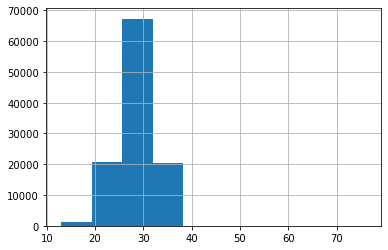

In [32]:
outputs.fragment.map(lambda x: len(x)).hist()

# RL

In [15]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)
loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

In [22]:
r_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2])

r_ds = Vec_Prediction_Dataset(['C'], [0], partial(failsafe_fp, fp_function=ECFP6))

r_agent = PredictiveAgent(r_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

r_agent.load_weights('../nbs/untracked_files/affinity_mlp.pt')

r_model.eval();

freeze(r_model)

reward = Reward(r_agent.predict_data, weight=-10.)

aff_reward = RewardCallback(reward, 'aff')

In [18]:
set_global_pool(cpus=8)

In [19]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.4, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [20]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

In [24]:
aff_reward = RewardCallback(reward, 'aff', sample_name='samples_fused')

In [25]:
template_cb = TemplateCallback(template, prefilter=True)

In [26]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_linker.pt'))
agent.base_model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_linker.pt'))

<All keys matched successfully>

In [27]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss],
                 cbs=cbs)

In [41]:
%%time
env.fit(200, 50, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
0,-1.826,-1.826,1.000,1.000,182,0.000,0.910,1.000,0.775,-1.666,1.000,-1.826,0.671,0.180,0.606
10,-1.611,-1.611,0.989,1.000,190,0.000,0.950,1.000,0.875,-1.856,0.986,-1.611,0.447,-0.225,0.478
20,-1.835,-1.835,0.955,1.000,179,0.000,0.895,1.000,0.738,-1.886,0.966,-1.835,0.647,-0.083,0.515
30,-1.680,-1.680,0.930,1.000,187,0.000,0.935,1.000,0.838,-1.782,0.955,-1.680,0.619,0.129,0.660
40,-1.498,-1.498,0.941,1.000,186,0.000,0.930,1.000,0.825,-1.478,0.955,-1.498,0.454,-0.217,0.209
50,-1.740,-1.740,0.947,1.000,188,0.000,0.940,1.000,0.850,-1.699,0.956,-1.740,0.556,0.117,0.522
60,-1.736,-1.736,0.921,0.995,189,0.000,0.945,0.986,0.863,-1.976,0.957,-1.736,0.582,0.198,0.566
70,-1.356,-1.356,0.899,1.000,188,0.000,0.940,1.000,0.850,-1.344,0.971,-1.356,0.460,0.146,0.654
80,-1.509,-1.509,0.894,1.000,189,0.000,0.945,1.000,0.863,-1.598,0.913,-1.509,0.488,-0.002,0.681
90,-1.517,-1.517,0.914,1.000,187,0.000,0.935,1.000,0.838,-1.423,0.985,-1.517,0.465,0.101,0.753


Epoch,Train Loss,Valid Loss,Time
0,1.92031,1.84956,00:00


Epoch,Train Loss,Valid Loss,Time
0,1.51403,1.64768,00:00


Epoch,Train Loss,Valid Loss,Time
0,1.48211,1.46102,00:00


Epoch,Train Loss,Valid Loss,Time
0,1.17174,0.99970,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.92405,1.00364,00:00


CPU times: user 2h 56min 25s, sys: 4min 6s, total: 3h 31s
Wall time: 12min 34s


In [42]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_linker.pt'))
agent.update_dataset_from_inputs(outputs.fragment.values)
agent.train_supervised(128, 3, 1e-4)
agent.update_dataset_from_inputs(env.log.df[env.log.df.aff>-.5].samples.values)
agent.train_supervised(128, 3, 1e-4)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.53651,0.51140,00:18
1,0.51196,0.50883,00:18
2,0.49791,0.50681,00:19


Epoch,Train Loss,Valid Loss,Time
0,0.68115,0.62457,00:03
1,0.56690,0.57635,00:03
2,0.57226,0.57092,00:03


<All keys matched successfully>

In [43]:
%%time
env.fit(200, 50, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
1000,-0.809,-0.809,0.444,1.000,171,0.000,0.855,1.000,0.637,-0.629,0.725,-0.809,0.418,0.374,0.712
1010,-0.449,-0.449,0.581,1.000,172,0.000,0.860,1.000,0.650,-0.496,0.577,-0.449,0.284,0.504,0.824
1020,-0.451,-0.451,0.660,1.000,159,0.000,0.795,1.000,0.487,-0.471,0.667,-0.451,0.215,0.463,0.725
1030,-0.371,-0.371,0.709,1.000,165,0.000,0.825,1.000,0.562,-0.284,0.800,-0.371,0.197,0.475,0.743
1040,-0.515,-0.515,0.718,1.000,163,0.000,0.815,1.000,0.537,-0.369,0.744,-0.515,0.283,0.635,0.807
1050,-0.440,-0.440,0.622,1.000,172,0.000,0.860,1.000,0.650,-0.447,0.673,-0.440,0.323,0.464,0.727
1060,-0.332,-0.332,0.608,1.000,166,0.000,0.830,1.000,0.575,-0.309,0.652,-0.332,0.250,0.546,0.857
1070,-0.237,-0.237,0.691,1.000,162,0.000,0.810,1.000,0.525,-0.169,0.833,-0.237,0.229,0.563,0.760
1080,-0.348,-0.348,0.630,1.000,165,0.000,0.825,1.000,0.562,-0.368,0.711,-0.348,0.184,0.443,0.676
1090,-0.154,-0.154,0.602,0.994,166,0.000,0.830,1.000,0.575,-0.195,0.587,-0.154,0.133,0.523,0.858


Epoch,Train Loss,Valid Loss,Time
0,0.45808,0.48729,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.51730,0.52238,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.42759,0.49864,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.43835,0.51368,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.52990,0.50346,00:00


CPU times: user 3h 12min 21s, sys: 4min 19s, total: 3h 16min 41s
Wall time: 10min 52s


In [44]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_linker.pt'))
agent.update_dataset_from_inputs(outputs.fragment.values)
agent.train_supervised(128, 3, 1e-4)
agent.update_dataset_from_inputs(env.log.df[env.log.df.aff>0.].samples.values)
agent.train_supervised(128, 3, 1e-4)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.53651,0.51140,00:18
1,0.51196,0.50883,00:18
2,0.49791,0.50681,00:18


Epoch,Train Loss,Valid Loss,Time
0,0.53728,0.62675,00:07
1,0.55716,0.59206,00:07
2,0.48842,0.58347,00:07


<All keys matched successfully>

In [45]:
%%time
env.fit(200, 50, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
2000,0.462,0.462,0.263,0.994,175,0.000,0.875,0.982,0.688,0.191,0.382,0.462,0.061,0.673,0.792
2010,0.050,0.050,0.436,1.000,179,0.000,0.895,1.000,0.738,0.103,0.407,0.050,0.136,0.777,0.863
2020,0.223,0.223,0.361,1.000,180,0.000,0.900,1.000,0.750,0.204,0.333,0.223,0.090,0.714,0.874
2030,0.267,0.267,0.426,0.995,183,0.000,0.915,0.984,0.787,0.239,0.429,0.267,0.068,0.692,0.848
2040,0.216,0.216,0.353,1.000,173,0.000,0.865,1.000,0.662,0.219,0.302,0.216,0.097,0.713,0.892
2050,0.294,0.294,0.301,1.000,176,0.000,0.880,1.000,0.700,0.402,0.143,0.294,0.081,0.792,0.983
2060,0.247,0.247,0.352,1.000,179,0.000,0.895,1.000,0.738,0.271,0.237,0.247,0.064,0.756,0.956
2070,0.317,0.317,0.348,1.000,184,0.000,0.920,1.000,0.800,0.259,0.391,0.317,0.035,0.759,0.890
2080,0.283,0.283,0.312,1.000,189,0.000,0.945,1.000,0.863,0.288,0.203,0.283,0.053,0.720,0.911
2090,0.324,0.324,0.328,1.000,180,0.000,0.900,1.000,0.750,0.396,0.300,0.324,0.023,0.781,0.949


Epoch,Train Loss,Valid Loss,Time
0,0.43948,0.37787,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.49299,0.41088,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.38595,0.43884,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.45281,0.48890,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.43667,0.46959,00:01


CPU times: user 3h 13min 52s, sys: 3min 34s, total: 3h 17min 26s
Wall time: 7min 50s


In [46]:
ref_reward = aff_reward._compute_reward([reference]).item()
ref_reward

0.06110673397779465

In [47]:
env.log.df[env.log.df.aff>ref_reward]

,samples,sources,rewards,rewards_final,template,samples_fused,aff,PPO
18,O=C(NC[2*:2])C(=O)NO[2*:1],base_buffer,0.184203,0.184203,0.0,O=C(NCn1ccnc1[N+](=O)[O-])C(=O)NOc1ccc2c(Nc3cc...,0.184203,-0.272620
25,O=C(CN(CC[2*:2])C[2*:1])NO,live_buffer,0.185297,0.185297,0.0,O=C(CN(CCn1ccnc1[N+](=O)[O-])Cc1ccc2c(Nc3ccc(F...,0.185297,-0.126422
43,O=C(NC[2*:2])C(CS)C[2*:1],live_buffer,0.319159,0.319159,0.0,O=C(NCn1ccnc1[N+](=O)[O-])C(CS)Cc1ccc2c(Nc3ccc...,0.319159,-0.236084
48,FC(OCC[2*:2])[2*:1],live_buffer,0.310266,0.310266,0.0,O=[N+]([O-])c1nccn1CCOC(F)c1ccc2c(Nc3ccc(F)c(C...,0.310266,-0.223458
59,CN(C(=O)CC[2*:2])C(CN)[2*:1],live_buffer,0.253294,0.253294,0.0,CN(C(=O)CCn1ccnc1[N+](=O)[O-])C(CN)c1ccc2c(Nc3...,0.253294,-0.301599
...,...,...,...,...,...,...,...,...
183857,NCNC(C[2*:1])=C([O-])CCC[2*:2],live_buffer,0.849290,0.849290,0.0,NCNC(Cc1ccc2c(Nc3ccc(F)c(Cl)c3)ncnc2c1)=C([O-]...,0.849290,-0.323093
183858,NNC(=O)C(CC[2*:2])=NCC[2*:1],base_buffer,0.481056,0.481056,0.0,NNC(=O)C(CCn1ccnc1[N+](=O)[O-])=NCCc1ccc2c(Nc3...,0.481056,1.143283
183859,CNC(N)(C[2*:1])C(=O)CC[2*:2],base_buffer,0.508909,0.508909,0.0,CNC(N)(Cc1ccc2c(Nc3ccc(F)c(Cl)c3)ncnc2c1)C(=O)...,0.508909,1.019785
183860,OCC(CC[2*:2])=C(CC[2*:1])NO,live,0.672409,0.672409,0.0,O=[N+]([O-])c1nccn1CCC(CO)=C(CCc1ccc2c(Nc3ccc(...,0.672409,0.377795


In [58]:
env.log.df[env.log.df.aff>1.12]

,samples,sources,rewards,rewards_final,template,samples_fused,aff,PPO
130804,NC(C[2*:1])=C([O-])CCCCC[2*:2],live,1.121121,1.121121,0.0,NC(Cc1ccc2c(Nc3ccc(F)c(Cl)c3)ncnc2c1)=C([O-])C...,1.121121,-1.604464
141731,NC(CC[2*:1])=C([O-])CCCCC[2*:2],live,1.130525,1.130525,0.0,NC(CCc1ccc2c(Nc3ccc(F)c(Cl)c3)ncnc2c1)=C([O-])...,1.130525,-1.702954
163438,NC(=O)NC(CCCC[2*:2])N[2*:1],live_buffer,1.128870,1.128870,0.0,NC(=O)NC(CCCCn1ccnc1[N+](=O)[O-])Nc1ccc2c(Nc3c...,1.128870,-1.106921
168723,NC(=CCCCC[2*:2])N=C([O-])C[2*:1],live,1.140739,1.140739,0.0,NC(=CCCCCn1ccnc1[N+](=O)[O-])N=C([O-])Cc1ccc2c...,1.140739,-1.348096
169987,NC(=NO)C(CCC[2*:2])N[2*:1],live_buffer,1.135213,1.135213,0.0,NC(=NO)C(CCCn1ccnc1[N+](=O)[O-])Nc1ccc2c(Nc3cc...,1.135213,-1.483931
177279,NC(=CCCC[2*:2])N=CC(=O)N[2*:1],live_buffer,1.137399,1.137399,0.0,NC(=CCCCn1ccnc1[N+](=O)[O-])N=CC(=O)Nc1ccc2c(N...,1.137399,-1.601003
181231,NCC(B[2*:1])=C([O-])CCCCC[2*:2],base_buffer,1.221768,1.221768,0.0,NCC(Bc1ccc2c(Nc3ccc(F)c(Cl)c3)ncnc2c1)=C([O-])...,1.221768,-2.274424


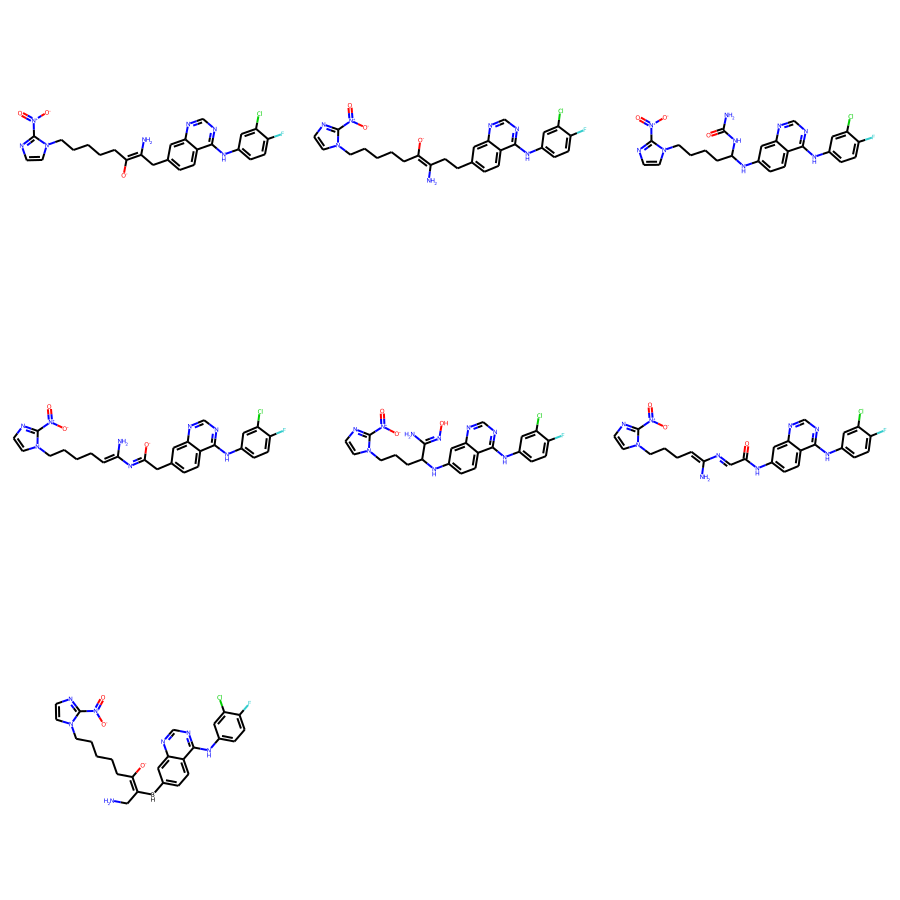

In [59]:
draw_mols(to_mols(env.log.df[env.log.df.aff>1.12].samples_fused.values))

In [50]:
pred_ds = r_ds.new(outputs.fused.values, [0 for i in outputs.fused.values])
pred_dl = pred_ds.dataloader(1000, num_workers=10)
preds = []
with torch.no_grad():
    for i, batch in enumerate(pred_dl):
        batch = to_device(batch)
        x,y = batch
        pred = r_model(x)
        preds.append(pred.detach().cpu().numpy())

In [51]:
preds = np.concatenate(preds)
outputs['aff'] = preds

In [52]:
outputs

,fragment,fused,pass,score,aff
2,[2*:2]C=CC(=O)NCCCNC[2*:1],O=C(C=Cn1ccnc1[N+](=O)[O-])NCCCNCc1ccc2c(Nc3cc...,True,0.0,0.008758
39,[2*:1]CCC(NC(=O)OC[2*:2])C(=O)O,O=C(NC(CCc1ccc2c(Nc3ccc(F)c(Cl)c3)ncnc2c1)C(=O...,True,0.0,0.003300
47,[2*:1]CNC(=O)C([2*:2])CCCC#N,N#CCCCC(C(=O)NCc1ccc2c(Nc3ccc(F)c(Cl)c3)ncnc2c...,True,0.0,0.259188
50,[2*:2]CCCN([2*:1])CCN(C)C,CN(C)CCN(CCCn1ccnc1[N+](=O)[O-])c1ccc2c(Nc3ccc...,True,0.0,0.026750
56,[2*:1]CC(N[2*:2])C(O)CC,CCC(O)C(Cc1ccc2c(Nc3ccc(F)c(Cl)c3)ncnc2c1)Nn1c...,True,0.0,0.249912
...,...,...,...,...,...
1167720,[2*:1]CC(COO)NC([2*:2])=O,O=C(NC(COO)Cc1ccc2c(Nc3ccc(F)c(Cl)c3)ncnc2c1)n...,True,0.0,0.133397
1167723,[2*:1]CCC(SCC([2*:2])=O)C(=O)O,O=C(O)C(CCc1ccc2c(Nc3ccc(F)c(Cl)c3)ncnc2c1)SCC...,True,0.0,0.021971
1167731,[2*:1]C([2*:2])(C#N)CC(C)=O,CC(=O)CC(C#N)(c1ccc2c(Nc3ccc(F)c(Cl)c3)ncnc2c1...,True,0.0,0.299534
1167756,[2*:1]CCC(=O)C([2*:2])C(C)=O,CC(=O)C(C(=O)CCc1ccc2c(Nc3ccc(F)c(Cl)c3)ncnc2c...,True,0.0,0.235313


In [53]:
outputs.aff.max()

0.76975167

In [54]:
env.log.df[env.log.df.aff>outputs.aff.max()]

,samples,sources,rewards,rewards_final,template,samples_fused,aff,PPO
1858,[O-][N+](=CC(O)C(O)C[2*:1])CCC[2*:2],live_buffer,0.815356,0.815356,0.0,O=[N+]([O-])c1nccn1CCC[N+]([O-])=CC(O)C(O)Cc1c...,0.815356,0.312923
2809,O=C(CS(=O)CCC[2*:2])N[2*:1],base_buffer,0.772537,0.772537,0.0,O=C(CS(=O)CCCn1ccnc1[N+](=O)[O-])Nc1ccc2c(Nc3c...,0.772537,-0.164627
2916,C(CNOCC[2*:2])C[2*:1],live,0.841624,0.841624,0.0,O=[N+]([O-])c1nccn1CCONCCCc1ccc2c(Nc3ccc(F)c(C...,0.841624,-0.129006
4231,OCC(CC[2*:1])C[2*:2],base_buffer,0.888476,0.888476,0.0,O=[N+]([O-])c1nccn1CC(CO)CCc1ccc2c(Nc3ccc(F)c(...,0.888476,-0.020193
5975,NC(CCCC[2*:2])C(=O)C[2*:1],base_buffer,0.834331,0.834331,0.0,NC(CCCCn1ccnc1[N+](=O)[O-])C(=O)Cc1ccc2c(Nc3cc...,0.834331,-0.204870
...,...,...,...,...,...,...,...,...
183852,O=S([O-])(=CC[2*:1])CCCC[2*:2],live_buffer,0.869657,0.869657,0.0,O=[N+]([O-])c1nccn1CCCCS(=O)([O-])=CCc1ccc2c(N...,0.869657,-0.404932
183853,O=C([O-])NC(=CCCC[2*:2])N[2*:1],base_buffer,0.947390,0.947390,0.0,O=C([O-])NC(=CCCCn1ccnc1[N+](=O)[O-])Nc1ccc2c(...,0.947390,-0.738958
183855,NC([O-])=C(CCCCCC[2*:2])C[2*:1],live_buffer,0.867286,0.867286,0.0,NC([O-])=C(CCCCCCn1ccnc1[N+](=O)[O-])Cc1ccc2c(...,0.867286,-0.418511
183856,O=C(N=C(CCCC[2*:2])NCO)[2*:1],live_buffer,0.833594,0.833594,0.0,O=C(N=C(CCCCn1ccnc1[N+](=O)[O-])NCO)c1ccc2c(Nc...,0.833594,-0.260710


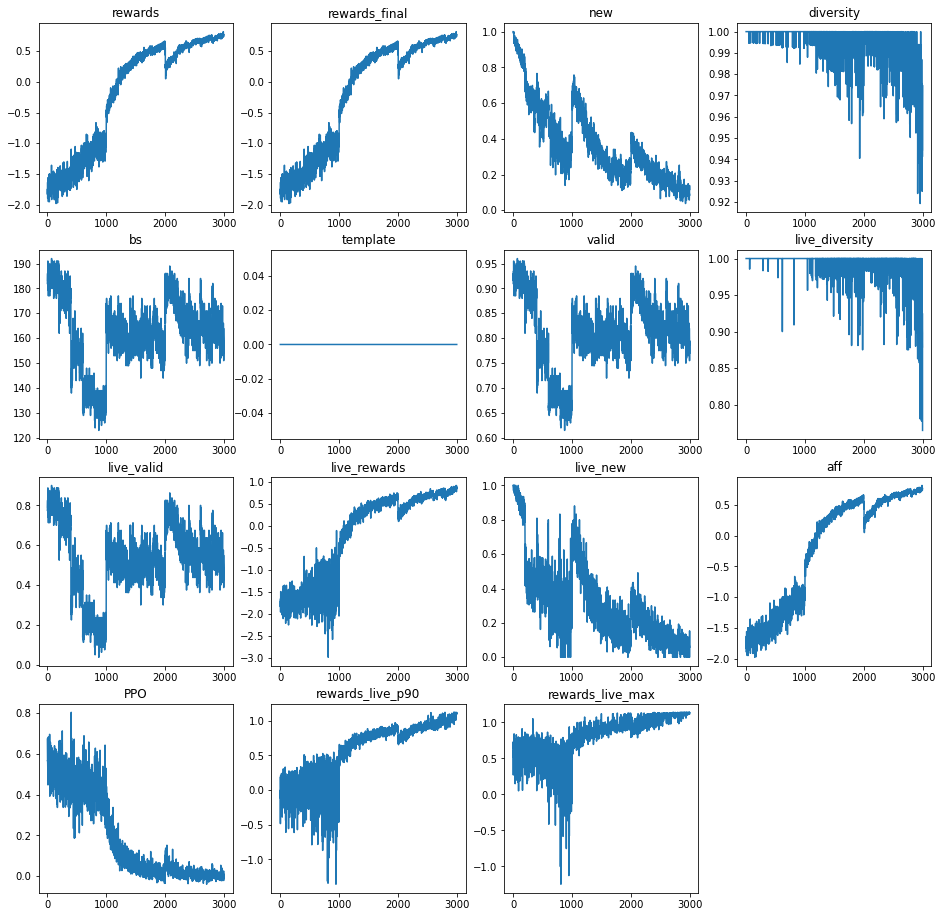

In [55]:
env.log.plot_metrics()